# Instalaciones

In [1]:
!pip install -q segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00


In [2]:
!pip install -q kaggle

# Importo librerias

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2

import os
import shutil
from tqdm import tqdm
import gc
import time
import copy
from collections import defaultdict
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda import amp
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F

import albumentations as A

import segmentation_models_pytorch as smp

# Configuraciones del Notebook

In [42]:
class CONFIG:
    path          = './dataset/'
    train_path    = './dataset/train'
    test_path     = './dataset/test'
    seed          = 42
    debug         = False
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    encoder_w     = 'imagenet'
    in_channels   = 3
    train_bs      = 128
    valid_bs      = train_bs*2
    img_size      = (224, 224)
    epochs        = 25
    lr            = 0.0025
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    gamma         = 0.85
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Descarga del dataset desde Kaggle

In [ ]:
from google.colab import files
# Cargo del API Token
files.upload()

In [6]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Para poder descargar, debemos inscribirnos en la competencia
!kaggle competitions download --force 'uw-madison-gi-tract-image-segmentation'

100% 2.30G/2.30G [02:16<00:00, 21.8MB/s]
100% 2.30G/2.30G [02:16<00:00, 18.1MB/s]


In [ ]:
!mkdir dataset

In [11]:
!unzip uw-madison-gi-tract-image-segmentation.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0131_266_2

In [12]:
# Imprimo carpetas dentro del path
os.listdir(CONFIG.path)

['train', 'sample_submission.csv', 'train.csv']

In [13]:
# Leo el archivo csv de train
df = pd.read_csv(f'{CONFIG.path}/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [14]:
print(df.shape)

(115488, 3)


## Divido en train y test

In [15]:
# Creo carpeta de 'test'
if not os.path.exists(CONFIG.test_path):
    os.makedirs(CONFIG.test_path)

# Voy a agregar 2 casos a la carpeta de test: caso 101 y caso 102
case_folder = ['case101', 'case102']

for subfolder in case_folder:
    source_path = os.path.join(CONFIG.train_path, subfolder)
    dest_path = os.path.join(CONFIG.test_path, subfolder)
    shutil.move(source_path, dest_path)

- Muevo los casos de test del dataframe de train al de test

In [ ]:
# Creo test dataframe
df_test = pd.DataFrame(columns=df.columns)

for index, row in df.iterrows():
  if row['id'].startswith('case101') or row['id'].startswith('case102'):
    # Lo copio al test df
    df_test = df_test.append(row)
    # Lo elimino del de train
    df.drop(index, inplace=True)

# Reset del index de train y test
df.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [17]:
df_test.sample(10)

,id,class,segmentation
527,case101_day32_slice_0032,stomach,NaN
475,case101_day32_slice_0015,small_bowel,NaN
1431,case101_day22_slice_0046,large_bowel,NaN
1445,case101_day22_slice_0050,stomach,NaN
1980,case101_day26_slice_0085,large_bowel,24427 1 24690 8 24955 11 25220 13 25486 14 257...
2135,case101_day26_slice_0136,stomach,NaN
961,case101_day20_slice_0033,small_bowel,NaN
1642,case101_day22_slice_0116,small_bowel,24842 1 24887 5 25105 6 25145 14 25370 9 25384...
334,case102_day0_slice_0112,small_bowel,34080 22 34438 26 34797 28 35156 30 35515 31 3...
1345,case101_day22_slice_0017,small_bowel,NaN


In [18]:
# Verifico haber eliminado los casos de train
is_case101 = df['id'].str.startswith('case101').any()
is_case102 = df['id'].str.startswith('case102').any()

print(f'Existe algún case101 en el set de train? {is_case101}')
print(f'Existe algún case102 en el set de train? {is_case102}')

Existe algún case101 en el set de train? False
Existe algún case102 en el set de train? False


# Exploratory Data Analysis

## Modifico Dataframe de Train

- Creo columnas con el numero de caso, el dia de la imagen y la slice de la imagen para cada dataframe

In [19]:
# Separo la columna id en diferentes columnas: case, day y slice
df['case'] = df['id'].apply(lambda x: x.split('_')[0].replace('case',''))
df['day'] = df['id'].apply(lambda x: x.split('_')[1].replace('day',''))
df['slice'] = df['id'].apply(lambda x: x.split('_')[3])

df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001
2,case123_day20_slice_0001,stomach,NaN,123,20,0001
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002


- Agrego columna con el path a cada slice

In [20]:
# Busco todas las imagenes png en la carpeta train y sus subcarpetas
train_images = glob(os.path.join(CONFIG.train_path, "**", "*.png"), recursive=True)

In [21]:
first_image_path = train_images[0]
x = first_image_path.rsplit("/", 4)[0]

path_partial_list = [os.path.join(x,
                                  "case" + str(df["case"].values[i]),
                                  "case" + str(df["case"].values[i]) + "_" + "day" + str(df["day"].values[i]),
                                  "scans",
                                  "slice_" + str(df["slice"].values[i]))
                     for i in range(df.shape[0])]
df["path_partial"] = path_partial_list

In [22]:
path_partial_list = [str(image_path.rsplit("_", 4)[0]) for image_path in train_images]

tmp_df = pd.DataFrame({"path_partial": path_partial_list, "path": train_images})

In [23]:
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])

In [24]:
df.sample(5)

,id,class,segmentation,case,day,slice,path
60606,case11_day12_slice_0075,large_bowel,34765 6 35124 8 35483 9 35843 9 36203 9 36563 ...,11,12,0075,./dataset/train/case11/case11_day12/scans/slic...
44264,case154_day13_slice_0099,stomach,NaN,154,13,0099,./dataset/train/case154/case154_day13/scans/sl...
69392,case35_day18_slice_0043,stomach,NaN,35,18,0043,./dataset/train/case35/case35_day18/scans/slic...
92655,case144_day14_slice_0022,large_bowel,NaN,144,14,0022,./dataset/train/case144/case144_day14/scans/sl...
98255,case78_day18_slice_0016,stomach,NaN,78,18,0016,./dataset/train/case78/case78_day18/scans/slic...


- Agrego columnas con el ancho y altura de la imagen

In [25]:
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
df.sample(5)

,id,class,segmentation,case,day,slice,path,width,height
76691,case141_day0_slice_0140,stomach,NaN,141,0,0140,./dataset/train/case141/case141_day0/scans/sli...,266,266
19824,case142_day14_slice_0049,large_bowel,NaN,142,14,0049,./dataset/train/case142/case142_day14/scans/sl...,266,266
113251,case30_day0_slice_0119,small_bowel,21222 6 21485 11 21750 13 22016 15 22282 16 22...,30,0,0119,./dataset/train/case30/case30_day0/scans/slice...,266,266
61445,case148_day20_slice_0066,stomach,NaN,148,20,0066,./dataset/train/case148/case148_day20/scans/sl...,360,310
14257,case110_day16_slice_0001,small_bowel,NaN,110,16,0001,./dataset/train/case110/case110_day16/scans/sl...,360,310


- Tengo 3 filas para un mismo slice porque estoy etiquetando las 3 clases posibles. Voy a modificar el dataframe para que haya 1 sola fila y 3 columnas que represente esta info: `large_bowel`, `small_bowel` y `stomach`. Estas columnas van a contenter los pixeles encoded con RLE donde se encuentra cada una de estas labels. Además, agrego una columna `count` que indica cuantos organos se encuentran en esa slice (0, 1, 2 o 3).

In [26]:
# Creo un nuevo dataframe, leyendo 1 cada 3 filas
df_train = pd.DataFrame({'id':df['id'][::3]})

# Creo nuevas columnas para cada clase y guardo los valores de los pixeles donde se encuentra ese organo
df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

# Guardo el resto de las columnas creadas en el primer df
df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values

# Creo nuevo indice y cambio NaN por string vacio
df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True);

# Agrego nueva columna que indica cuantos objetos hay presentes en la imagen (0, 1, 2 o 3)
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(10)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
2664,case130_day0_slice_0073,29994 8 30259 11 30524 13 30790 13 31056 13 31...,34235 4 34499 9 34764 12 35029 14 35294 16 355...,29163 14 29427 18 29691 22 29955 25 30219 27 3...,./dataset/train/case130/case130_day0/scans/sli...,130,0,0073,266,266,3
11582,case113_day22_slice_0095,34318 9 34675 13 35032 16 35390 19 35747 22 36...,32228 12 32560 14 32587 17 32918 18 32947 19 3...,,./dataset/train/case113/case113_day22/scans/sl...,113,22,0095,360,310,2
26797,case81_day28_slice_0142,,,,./dataset/train/case81/case81_day28/scans/slic...,81,28,0142,266,266,0
12044,case113_day16_slice_0125,,,,./dataset/train/case113/case113_day16/scans/sl...,113,16,0125,360,310,0
37575,case30_day1_slice_0088,18982 9 19245 13 19509 17 19579 10 19774 19 19...,25487 5 25751 8 25939 14 26016 10 26204 18 262...,19015 3 19279 10 19543 14 19804 21 20068 24 20...,./dataset/train/case30/case30_day1/scans/slice...,30,1,0088,266,266,3
27921,case36_day14_slice_0018,,,,./dataset/train/case36/case36_day14/scans/slic...,36,14,0018,266,266,0
16022,case84_day0_slice_0071,,,,./dataset/train/case84/case84_day0/scans/slice...,84,0,0071,266,266,0
3433,case88_day0_slice_0122,23327 2 23686 7 24046 9 24406 11 24766 13 2512...,16405 1 16762 8 17121 11 17460 3 17480 15 1781...,,./dataset/train/case88/case88_day0/scans/slice...,88,0,0122,360,310,2
4608,case110_day12_slice_0001,,,,./dataset/train/case110/case110_day12/scans/sl...,110,12,0001,360,310,0
30233,case138_day0_slice_0026,,,,./dataset/train/case138/case138_day0/scans/sli...,138,0,0026,266,266,0


- Valores nulos

In [27]:
# Verifico si hay valores nulos en las clases
for i in range(3):
    column_index = i + 1
    column_name = df_train.columns[column_index]
    has_null_values = df_train[column_name].isnull().any()
    print(f'La columna {column_name} tiene valores nulos? {has_null_values}')

La columna large_bowel tiene valores nulos? False
La columna small_bowel tiene valores nulos? False
La columna stomach tiene valores nulos? False


- Visualizo cantidad de imágenes con 0 órganos, 1 órgano, 2 órganos y 3 órganos.

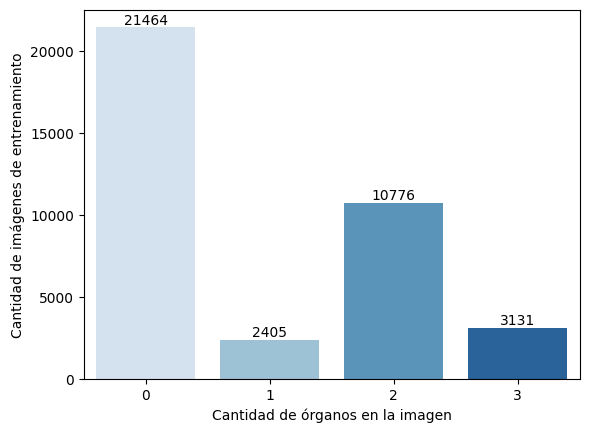

In [28]:
sns.countplot(x='count', data=df_train, palette='Blues')
plt.xlabel('Cantidad de órganos en la imagen')
plt.ylabel('Cantidad de imágenes de entrenamiento')

count_value_counts = df_train['count'].value_counts().sort_index()
for i, count in enumerate(count_value_counts):
    plt.text(i, count - 10, str(count), ha='center', va='bottom')

plt.show()

- Visualizo cuantas imagenes de entrenamiento tienen una máscara de cada clase.

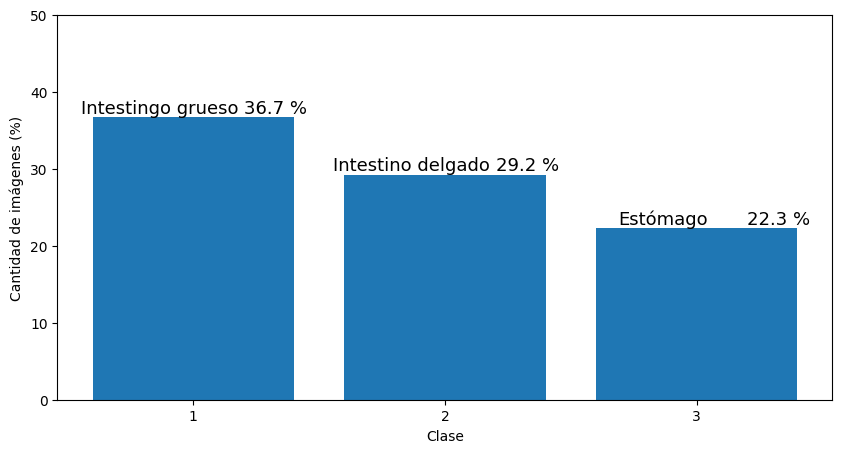

In [29]:
plt.figure(figsize=(10,5))
bar = plt.bar([1, 2, 3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))
plt.ylabel('Cantidad de imágenes (%)'); plt.xlabel('Clase')
plt.xticks([1, 2, 3])
labels=['Intestingo grueso','Intestino delgado','Estómago']
for rect, lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=13)
    plt.text(rect.get_x() + rect.get_width()/1.1, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

## Decodificación de las máscaras

Las máscaras se encuentran encodeadas en un formato RLE (run-length encoding). Se utiliza para codificar la ubicación de los objetos de primer plano en la segmentación. En lugar de generar una imagen de máscara, proporciona una lista de píxeles de inicio y cuántos píxeles después de cada uno de esos inicios se incluyen en la máscara.

La regla de codificación es bastante simple:

    Índice de la máscara. Cuántos píxeles sigue.

Por ejemplo, el `RLE = '4 1 6 1 8 3'` es:

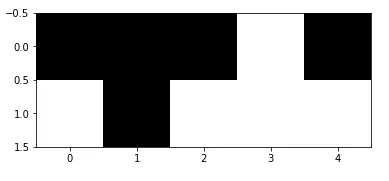


Se va a hacer un decoding de estos embeddings para poder visualizar las máscaras sobre las imágenes.
El código es tomado de: [Run-Length Encode and Decode](https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script)

In [30]:
def rle_decode(mask_rle, shape):
  '''
  Arguments:
  - mask_rle: run-length as string formated (start length)
  - shape: (height, width) of array to return
  Returns:
  - numpy array, 1 - mask, 0 - background
  '''
  s = mask_rle.split()
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths
  img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
  for lo, hi in zip(starts, ends):
      img[lo:hi] = 1
  return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
  '''
  Arguments:
  - img: numpy array, 1 - mask, 0 - background
  Returns:
  - run length as string formated
  '''
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)


def show_img(img, mask=None):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  plt.imshow(img, cmap='bone')

  if mask is not None:
    plt.imshow(mask, alpha=0.5)
    handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
    labels = ["Large Bowel", "Small Bowel", "Stomach"]
    plt.legend(handles,labels)
  plt.axis('off')

- Preservo las filas del dataframe que tienen una máscara

In [31]:
# Agrego indices de mascaras a una lista llamada train_mask
# (las que presentan valores de pixeles en las columnas large_bowel, small_bowel o stomach )
train_mask = list(df_train[df_train['large_bowel']!=''].index)
train_mask += list(df_train[df_train['small_bowel']!=''].index)
train_mask += list(df_train[df_train['stomach']!=''].index)

# Filtro el datraframe y guardo solamente las filas que tienen una máscara
df_train = df_train[df_train.index.isin(train_mask)]
# Reseteo los indices para comenzar en 0 y ser secuenciales
df_train.reset_index(inplace=True, drop=True)
print(f'El dataframe de entrenamiento tiene el shape: {df_train.shape}')

El dataframe de entrenamiento tiene el shape: (16312, 11)


In [44]:
from sklearn.model_selection import StratifiedGroupKFold

# Inicializo K fold cross validation
skf = StratifiedGroupKFold(n_splits = CONFIG.n_fold,
                           shuffle=True,
                           random_state=42)

# Para cada uno de los 5 splits de skf, asigno un numero de fold a cada set de validación
# basado en el grupo especificado por df_train['case'] (cada caso es un paciente)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'], groups=df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold

# Convierto a uint 8
df_train['fold'] = df_train['fold'].astype(np.uint8)

# Selecciono indices de entrenamiento y validacion
train_ids = df_train[df_train["fold"]!= 1].index
valid_ids = df_train[df_train["fold"]== 1].index

# Agrupo la data de entrenamiento segun el fold al que corresponde e imprimo la
# cantidad de veces que se presenta cada clase
df_train.groupby(['fold', 'count']).size()

fold  count
1     1         543
      2        2577
      3         734
2     1         412
      2        1809
      3         487
3     1         504
      2        1735
      3         719
4     1         465
      2        2037
      3         592
5     1         481
      2        2618
      3         599
dtype: int64

# Dataset

In [45]:
class BuildDataset(torch.utils.data.Dataset):
  def __init__(self, df, subset="train", augment=None):
    self.df = df
    self.subset = subset
    self.augment = augment

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    # Defino tamaño de mascara igual al tamaño de las imagenes
    masks = np.zeros((CONFIG.img_size[0], CONFIG.img_size[1], 3), dtype=np.float32)
    # Path a la imagen
    img_path = self.df['path'].iloc[index]
    # Defino width y height
    w = self.df['width'].iloc[index]
    h = self.df['height'].iloc[index]
    # Llamo a la funcion load_image
    img = self.__load_image__(img_path)

    if self.subset == 'train':
      for k, j in zip([0, 1, 2], ["large_bowel", "small_bowel", "stomach"]):
        rles = self.df[j].iloc[index]
        # Decoding de la mascara
        mask = rle_decode(rles, shape=(h, w, 1))
        # Resize de la mascara
        mask = cv2.resize(mask, CONFIG.img_size)
        masks[:,:,k] = mask

    masks = masks.transpose(2, 0, 1)
    img = img.transpose(2, 0, 1)

    if self.subset == 'train':
      return torch.tensor(img), torch.tensor(masks)
    else:
      return torch.tensor(img)

  def __load_image__(self, img_path):
    # Leo imagen del path
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    # Normalizo la imagen
    img = (img - img.min())/(img.max() - img.min())*255.0
    # Resize al tamaño definido en configuraciones
    img = cv2.resize(img, CONFIG.img_size)
    # Gray 2 rgb
    img = np.tile(img[..., None], [1, 1, 3])
    img = img.astype(np.float32) /255.0
    return img

# Data Augmentation

In [46]:
data_augmentation = {
                    "train": A.Compose([
                                        A.Resize(*CONFIG.img_size, interpolation=cv2.INTER_NEAREST),
                                        A.HorizontalFlip(p=0.5),
                                        A.VerticalFlip(p=0.5),
                                        A.OneOf([
                                                A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                                                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
                                                A.RandomBrightnessContrast(),
                                                ], p=0.25),

                                        ], p=1.0),
                    "valid": A.Compose([
                                        A.Resize(*CONFIG.img_size, interpolation=cv2.INTER_NEAREST),
                                        ], p=1.0)
                  }

# Definicion del modelo

- Modelo: UNet
  - Se emplea [segmentation-models-pytorch](https://pypi.org/project/segmentation-models-pytorch/0.0.3/). Su principal ventaja es que se pueden usar pesos pre-entrenados en los encoders.

In [47]:
def build_model():
    model = smp.Unet(
                    encoder_name    = CONFIG.backbone,      # encoder elegido en configuraciones
                    encoder_weights = CONFIG.encoder_w,     # inicializo el encoder con los pesos pre-entrenados para el dataset `imagenet`
                    in_channels     = CONFIG.in_channels,   # 3 canales (imagen RGB)
                    classes         = CONFIG.num_classes,   # 3 clases de salida
                    activation      = None,
                    )
    model.to(CONFIG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

- Defino loss function y métricas a medir: Dice y IoU

In [48]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss = smp.losses.DiceLoss(mode='multilabel')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
  # Dice Coeficient
  y_true = y_true.to(torch.float32)
  y_pred = (y_pred>thr).to(torch.float32)
  inter = (y_true*y_pred).sum(dim=dim)
  den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
  dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
  return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
  # IoU coeficient
  y_true = y_true.to(torch.float32)
  y_pred = (y_pred>thr).to(torch.float32)
  inter = (y_true*y_pred).sum(dim=dim)
  union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
  iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
  return iou

def loss_function(y_pred, y_true):
  #return 0.6*BCELoss(y_pred, y_true) + 0.4*DiceLoss(y_pred, y_true)
  return DiceLoss(y_pred, y_true)

## Función de entrenamiento

In [49]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
  model.train()
  scaler = amp.GradScaler()

  dataset_size = 0
  running_loss = 0.0

  # Progress bar
  pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
  for step, (images, masks) in pbar:
    images = images.to(device, dtype=torch.float)
    masks  = masks.to(device, dtype=torch.float)

    batch_size = images.size(0)

    with amp.autocast(enabled=True):
      y_pred = model(images)
      loss   = loss_function(y_pred, masks)
      loss   = loss / CONFIG.n_accumulate

    scaler.scale(loss).backward()

    if (step + 1) % CONFIG.n_accumulate == 0:
      scaler.step(optimizer)
      scaler.update()

      optimizer.zero_grad()

      if scheduler is not None:
        scheduler.step()

    running_loss += (loss.item() * batch_size)
    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size

    mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
    current_lr = optimizer.param_groups[0]['lr']
    pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                    lr=f'{current_lr:0.5f}',
                    gpu_mem=f'{mem:0.2f} GB')
  torch.cuda.empty_cache()
  gc.collect()

  return epoch_loss

## Función de validacion

In [50]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
  model.eval()

  dataset_size = 0
  running_loss = 0.0

  val_scores = []

  # Progress bar
  pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
  for step, (images, masks) in pbar:
    images  = images.to(device, dtype=torch.float)
    masks   = masks.to(device, dtype=torch.float)

    batch_size = images.size(0)

    y_pred  = model(images)
    loss    = loss_function(y_pred, masks)

    running_loss += (loss.item() * batch_size)
    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size

    # Uso sigmoid porque estamos en presencia de multi label classification
    y_pred = nn.Sigmoid()(y_pred)
    # Metricas de validacion
    val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
    val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
    val_scores.append([val_dice, val_jaccard])

    mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
    current_lr = optimizer.param_groups[0]['lr']
    pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                    lr=f'{current_lr:0.5f}',
                    gpu_memory=f'{mem:0.2f} GB')

  val_scores  = np.mean(val_scores, axis=0)
  torch.cuda.empty_cache()
  gc.collect()

  return epoch_loss, val_scores

## Funcion para correr el modelo

In [51]:
def run_training(model, optimizer, scheduler, train_loader, valid_loader, device, num_epochs):
  # Log de gradientes
  if torch.cuda.is_available():
      print("cuda: {}\n".format(torch.cuda.get_device_name()))

  # Inicializo variables
  start = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_dice = -np.inf
  best_epoch = -1
  history = defaultdict(list)

  for epoch in range(1, num_epochs+1):
    gc.collect()
    print(f'Epoch {epoch}/{num_epochs}', end='')

    # Llamo a funcion de entrenamiento
    train_loss = train_one_epoch(model,
                                  optimizer,
                                  scheduler,
                                  dataloader=train_loader,
                                  device= CONFIG.device,
                                  epoch=epoch)
    # Llamo a funcion de validacion
    val_loss, val_scores = valid_one_epoch(model,
                                            valid_loader,
                                            device= CONFIG.device,
                                            epoch=epoch)
    # Obtengo Dice y IoU
    val_dice, val_jaccard = val_scores
    print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')

    # Guardo metricas de validacion y losses
    history['Train Loss'].append(train_loss)
    history['Valid Loss'].append(val_loss)
    history['Valid Dice'].append(val_dice)
    history['Valid Jaccard'].append(val_jaccard)

    # Imprimo si mejoró el modelo (metrica elegida: Dice)
    if val_dice >= best_dice:
      print(f"Dice mejoró ({best_dice:0.4f} ---> {val_dice:0.4f})")
      # Update nuevo mejor valor de dice e IoU y la epoch a la que corresponde
      best_dice = val_dice
      best_jaccard = val_jaccard
      best_epoch = epoch

      # Guardo el mejor modelo
      best_model_wts = copy.deepcopy(model.state_dict())
      PATH = f"best_epoch-{fold:02d}.bin"
      torch.save(model.state_dict(), PATH)
      print(f"Modelo Guardado")

    last_model_wts = copy.deepcopy(model.state_dict())
    PATH = f"last_epoch-{fold:02d}.bin"
    torch.save(model.state_dict(), PATH)

    print('\n\n')

  end = time.time()
  time_elapsed = end - start
  print('-'*35)
  print('Entrenamiento finalizado en {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
  print("Mejor IoU: {:.4f}".format(best_jaccard))
  print("Mejor Dice: {:.4f}".format(best_dice))
  print('-'*35)

  # Cargo los pesos del mejor modelo
  model.load_state_dict(best_model_wts)

  return model, history

### Definición del optimizador

- Ajuste del learning rate con el `scheduler`. Ver definiciones [aqui](https://pytorch.org/docs/stable/optim.html).

In [52]:
def get_scheduler(optimizer):
  if CONFIG.scheduler == 'CosineAnnealingLR':
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                T_max = CONFIG.T_max,
                                                eta_min = CONFIG.min_lr)
  elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                          T_0 = CONFIG.T_0,
                                                          eta_min = CONFIG.min_lr)
  elif CONFIG.scheduler == 'ReduceLROnPlateau':
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                mode='min',
                                                factor=0.1,
                                                patience=7,
                                                threshold=0.0001,
                                                min_lr=CONFIG.min_lr,)
  elif CONFIG.scheduler == 'ExponentialLR':
    scheduler = lr_scheduler.ExponentialLR(optimizer,
                                            gamma= CONFIG.gamma)
  elif CONFIG.scheduler == None:
    return None

  return scheduler

- Defino `Adam` como optimizador.

In [53]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.wd)
scheduler = get_scheduler(optimizer) # debo definir en clase CONFIG

In [55]:
print(f'#'*35)
print(f'Comienza entrenamiento \nNúmero de epochs: {CONFIG.epochs}')
print(f'#'*35)

# El split retorna los indices de entrenamiento y validacion. Agrupo por casos para evitar data leak (imagenes de un mismo paciente en train y val)
for _ in range(1):

  # Creo dataset de train y valid (con data augmentation)
  train_dataset = BuildDataset(df_train[df_train.index.isin(train_ids)],
                               augment = data_augmentation['train'])
  valid_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)],
                               augment = data_augmentation['valid'])

  # Defino Data Loaders de entrenamiento y valid
  train_loader = DataLoader(train_dataset,
                            batch_size = CONFIG.train_bs,
                            num_workers=2,
                            shuffle=True,
                            pin_memory=True,
                            drop_last=False)

  valid_loader = DataLoader(valid_dataset,
                            batch_size = CONFIG.valid_bs,
                            num_workers=2,
                            shuffle=False,
                            pin_memory=True)

  loaders = {"train": train_loader,
             "valid": valid_loader}

  model = build_model()
  optimizer = optim.Adam(model.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.wd)
  scheduler = get_scheduler(optimizer)
  model, history = run_training(model,
                                optimizer,
                                scheduler,
                                train_loader,
                                valid_loader,
                                device = CONFIG.device,
                                num_epochs = CONFIG.epochs)

print('Finalizó el entrenamiento.')

###################################
Comienza entrenamiento 
Número de epochs: 25
###################################
cuda: Tesla T4

Epoch 1/25

Valid : 100%|██████████| 16/16 [00:29<00:00,  1.83s/it, gpu_memory=11.35 GB, lr=0.00250, valid_loss=0.6199]


Valid Dice: 0.4265 | Valid Jaccard: 0.3725
Dice mejoró (-inf ---> 0.4265)
Modelo Guardado



Epoch 2/25

Valid : 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, gpu_memory=11.36 GB, lr=0.00249, valid_loss=0.4261]


Valid Dice: 0.6225 | Valid Jaccard: 0.5510
Dice mejoró (0.4265 ---> 0.6225)
Modelo Guardado



Epoch 3/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, gpu_memory=11.42 GB, lr=0.00248, valid_loss=0.3546]


Valid Dice: 0.5585 | Valid Jaccard: 0.4708



Epoch 4/25

Valid : 100%|██████████| 16/16 [00:28<00:00,  1.75s/it, gpu_memory=11.38 GB, lr=0.00247, valid_loss=0.2715]


Valid Dice: 0.7145 | Valid Jaccard: 0.6301
Dice mejoró (0.6225 ---> 0.7145)
Modelo Guardado



Epoch 5/25

Valid : 100%|██████████| 16/16 [00:26<00:00,  1.69s/it, gpu_memory=11.42 GB, lr=0.00246, valid_loss=0.2706]


Valid Dice: 0.6124 | Valid Jaccard: 0.5294



Epoch 6/25

Valid : 100%|██████████| 16/16 [00:26<00:00,  1.64s/it, gpu_memory=11.43 GB, lr=0.00244, valid_loss=0.2104]


Valid Dice: 0.7806 | Valid Jaccard: 0.7046
Dice mejoró (0.7145 ---> 0.7806)
Modelo Guardado



Epoch 7/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, gpu_memory=11.43 GB, lr=0.00242, valid_loss=0.2033]


Valid Dice: 0.7988 | Valid Jaccard: 0.7231
Dice mejoró (0.7806 ---> 0.7988)
Modelo Guardado



Epoch 8/25

Valid : 100%|██████████| 16/16 [00:38<00:00,  2.41s/it, gpu_memory=11.38 GB, lr=0.00239, valid_loss=0.1944]


Valid Dice: 0.8051 | Valid Jaccard: 0.7309
Dice mejoró (0.7988 ---> 0.8051)
Modelo Guardado



Epoch 9/25

Valid : 100%|██████████| 16/16 [00:28<00:00,  1.79s/it, gpu_memory=11.23 GB, lr=0.00237, valid_loss=0.2075]


Valid Dice: 0.7997 | Valid Jaccard: 0.7255



Epoch 10/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, gpu_memory=11.43 GB, lr=0.00233, valid_loss=0.2120]


Valid Dice: 0.7875 | Valid Jaccard: 0.7110



Epoch 11/25

Valid : 100%|██████████| 16/16 [00:29<00:00,  1.81s/it, gpu_memory=11.43 GB, lr=0.00230, valid_loss=0.2064]


Valid Dice: 0.8082 | Valid Jaccard: 0.7341
Dice mejoró (0.8051 ---> 0.8082)
Modelo Guardado



Epoch 12/25

Valid : 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, gpu_memory=11.43 GB, lr=0.00226, valid_loss=0.2035]


Valid Dice: 0.7972 | Valid Jaccard: 0.7210



Epoch 13/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, gpu_memory=11.38 GB, lr=0.00222, valid_loss=0.2192]


Valid Dice: 0.7751 | Valid Jaccard: 0.6999



Epoch 14/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, gpu_memory=11.38 GB, lr=0.00218, valid_loss=0.2077]


Valid Dice: 0.7998 | Valid Jaccard: 0.7262



Epoch 15/25

Valid : 100%|██████████| 16/16 [00:26<00:00,  1.69s/it, gpu_memory=11.28 GB, lr=0.00214, valid_loss=0.2109]


Valid Dice: 0.7988 | Valid Jaccard: 0.7231



Epoch 16/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, gpu_memory=11.43 GB, lr=0.00209, valid_loss=0.2009]


Valid Dice: 0.8087 | Valid Jaccard: 0.7352
Dice mejoró (0.8082 ---> 0.8087)
Modelo Guardado



Epoch 17/25

Valid : 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, gpu_memory=11.38 GB, lr=0.00204, valid_loss=0.1987]


Valid Dice: 0.8058 | Valid Jaccard: 0.7317



Epoch 18/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, gpu_memory=11.43 GB, lr=0.00199, valid_loss=0.2044]


Valid Dice: 0.8008 | Valid Jaccard: 0.7262



Epoch 19/25

Valid : 100%|██████████| 16/16 [00:25<00:00,  1.61s/it, gpu_memory=11.43 GB, lr=0.00194, valid_loss=0.1947]


Valid Dice: 0.8052 | Valid Jaccard: 0.7312



Epoch 20/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.73s/it, gpu_memory=11.43 GB, lr=0.00188, valid_loss=0.1995]


Valid Dice: 0.8016 | Valid Jaccard: 0.7273



Epoch 21/25

Valid : 100%|██████████| 16/16 [00:28<00:00,  1.76s/it, gpu_memory=11.38 GB, lr=0.00182, valid_loss=0.1977]


Valid Dice: 0.8067 | Valid Jaccard: 0.7324



Epoch 22/25

Valid : 100%|██████████| 16/16 [00:27<00:00,  1.73s/it, gpu_memory=11.43 GB, lr=0.00177, valid_loss=0.1982]


Valid Dice: 0.8024 | Valid Jaccard: 0.7270



Epoch 23/25

Valid : 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, gpu_memory=11.43 GB, lr=0.00171, valid_loss=0.1974]


Valid Dice: 0.7981 | Valid Jaccard: 0.7239



Epoch 24/25

Valid : 100%|██████████| 16/16 [00:28<00:00,  1.79s/it, gpu_memory=11.38 GB, lr=0.00164, valid_loss=0.2015]


Valid Dice: 0.7958 | Valid Jaccard: 0.7211



Epoch 25/25

Valid : 100%|██████████| 16/16 [00:28<00:00,  1.76s/it, gpu_memory=11.43 GB, lr=0.00158, valid_loss=0.2046]


Valid Dice: 0.7987 | Valid Jaccard: 0.7230



-----------------------------------
Entrenamiento finalizado en 0h 54m 39s
Mejor IoU: 0.7352
Mejor Dice: 0.8087
-----------------------------------
Finalizó el entrenamiento.


- Grafico Dice y IoU en entrenamiento

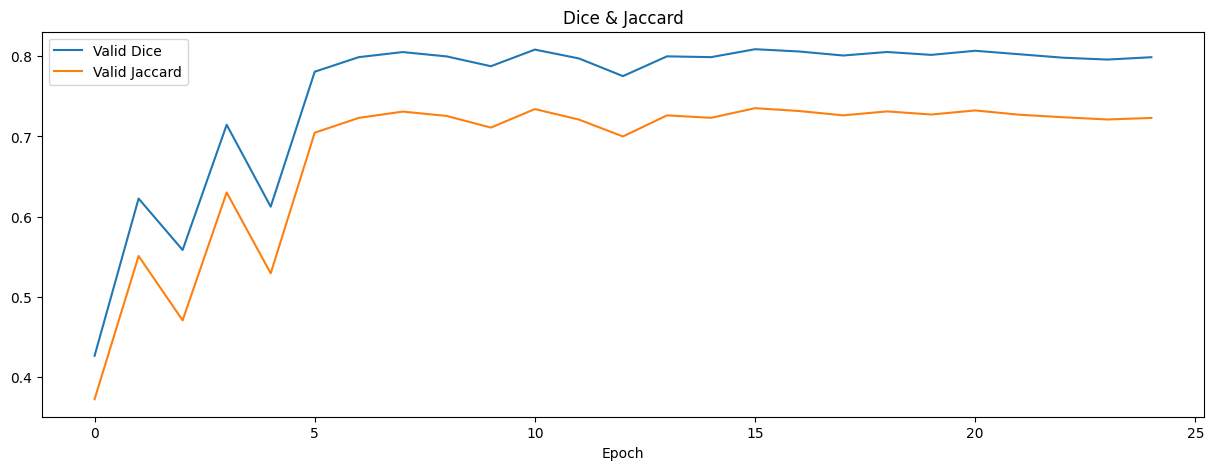

In [56]:
plt.figure(figsize=(15,5))
plt.plot(range(CONFIG.epochs),history['Valid Dice'],label='Valid Dice')
plt.plot(range(CONFIG.epochs),history['Valid Jaccard'],label='Valid Jaccard')
plt.title('Dice & Jaccard'); plt.xlabel('Epoch'); plt.ylabel('');plt.legend();
plt.show()

- Grafico Loss en entrenamiento

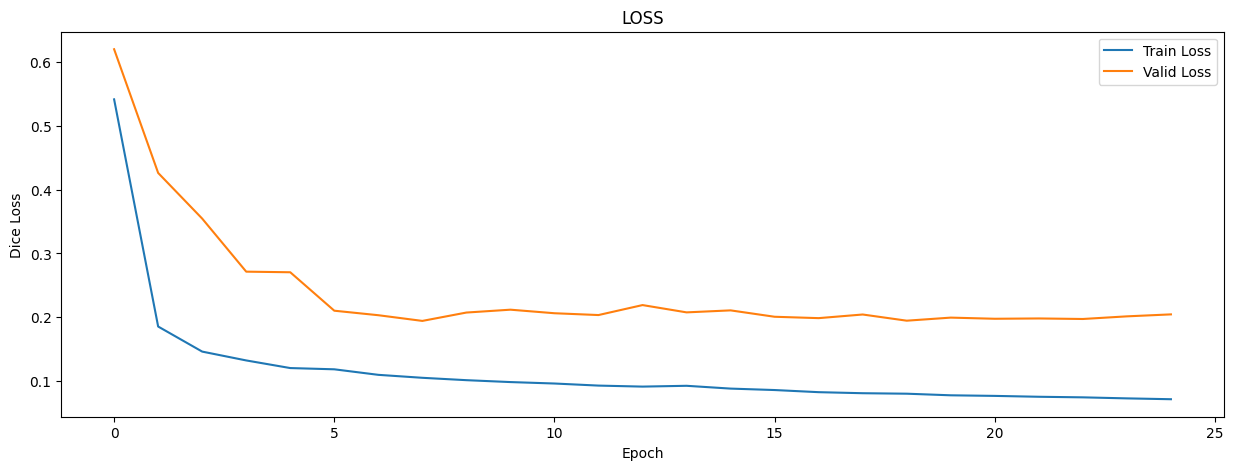

In [57]:
plt.figure(figsize=(15,5))
plt.plot(range(CONFIG.epochs),history['Train Loss'],label='Train Loss')
plt.plot(range(CONFIG.epochs),history['Valid Loss'],label='Valid Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('Dice Loss');plt.legend();
plt.show()

## Predicciones

Visualizo batch de imagenes + mascaras

In [58]:
def plot_batch(images, masks, size=3):
  plt.figure(figsize=(20, 15))
  for idx in range(size):
      plt.subplot(1, 5, idx+1)
      img = images[idx,].permute((1, 2, 0)).numpy()
      mask = masks[idx,].permute((1, 2, 0)).numpy()
      show_img(img, mask)
  plt.tight_layout()
  plt.show()

In [60]:
test_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)],
                            augment = data_augmentation['valid'])

test_loader = DataLoader(test_dataset,
                         batch_size=5,
                         num_workers=2,
                         shuffle=False,
                         pin_memory=True)

imgs, msks = next(iter(test_loader))

imgs = imgs.to(CONFIG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-05.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

- Mascaras

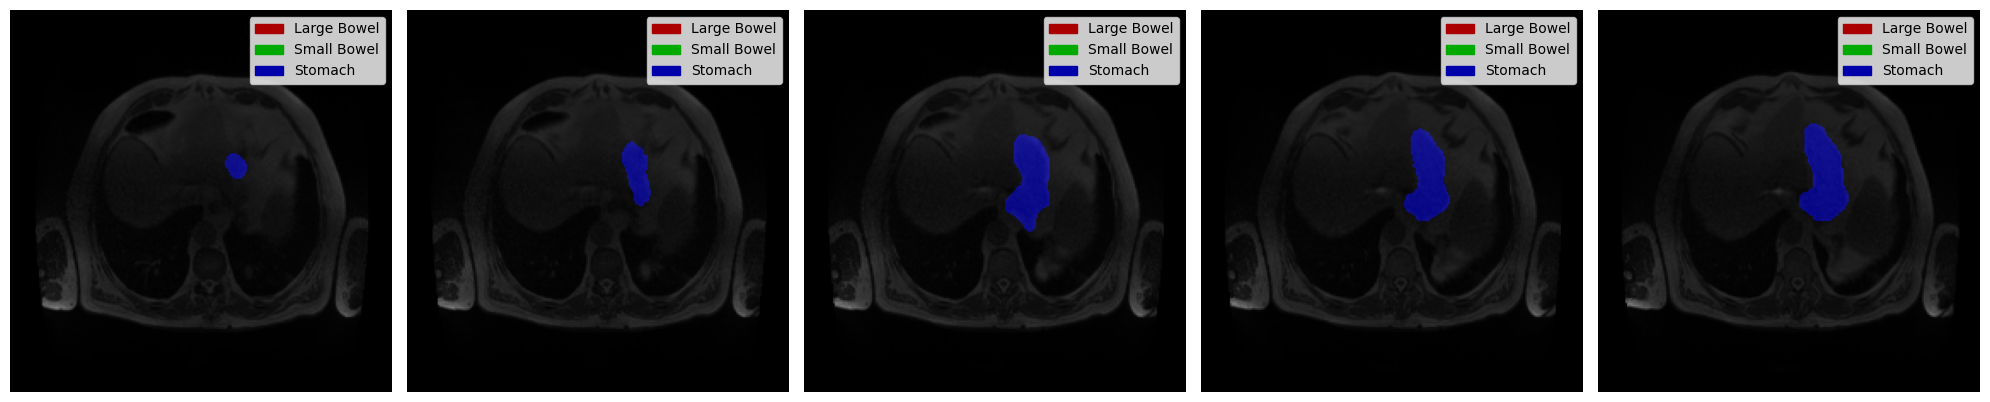

In [61]:
plot_batch(imgs, msks, size=5)

- Predicciones

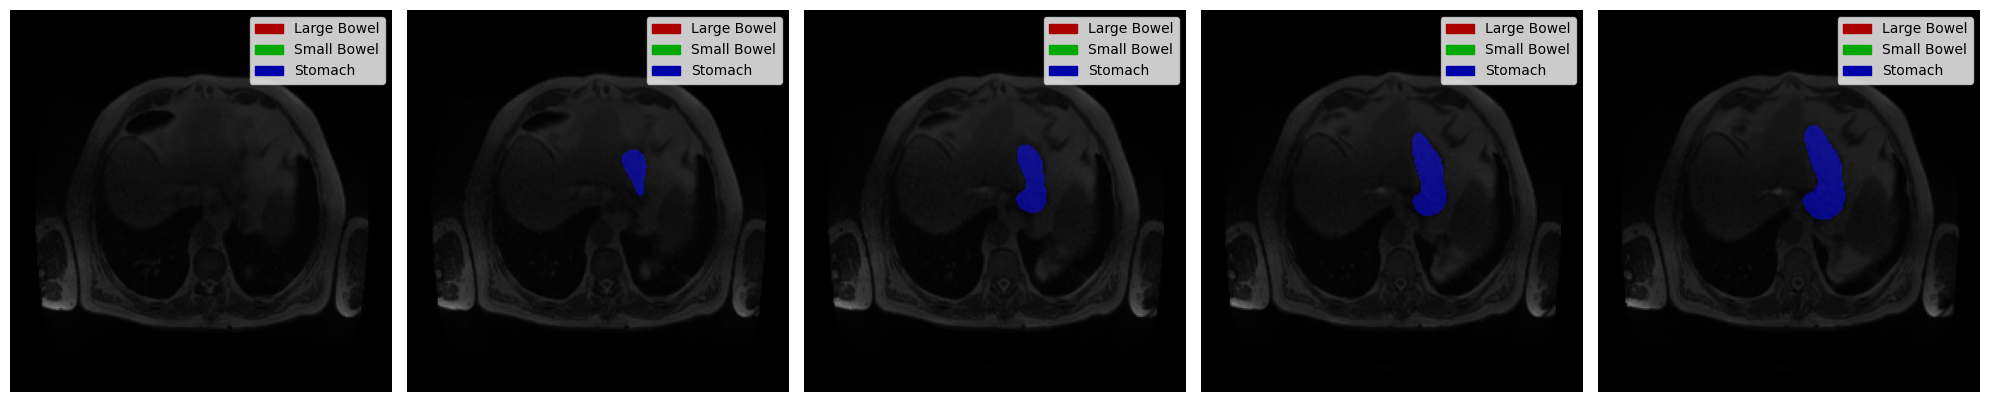

In [62]:
plot_batch(imgs, preds, size=5)

In [64]:
test_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)],
                            augment=data_augmentation['valid'])

test_loader  = DataLoader(test_dataset, batch_size=5,
                          num_workers=2,
                          shuffle=True,
                          pin_memory=True)

imgs, msks =  next(iter(test_loader))

imgs = imgs.to(CONFIG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-05.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

- Mascaras

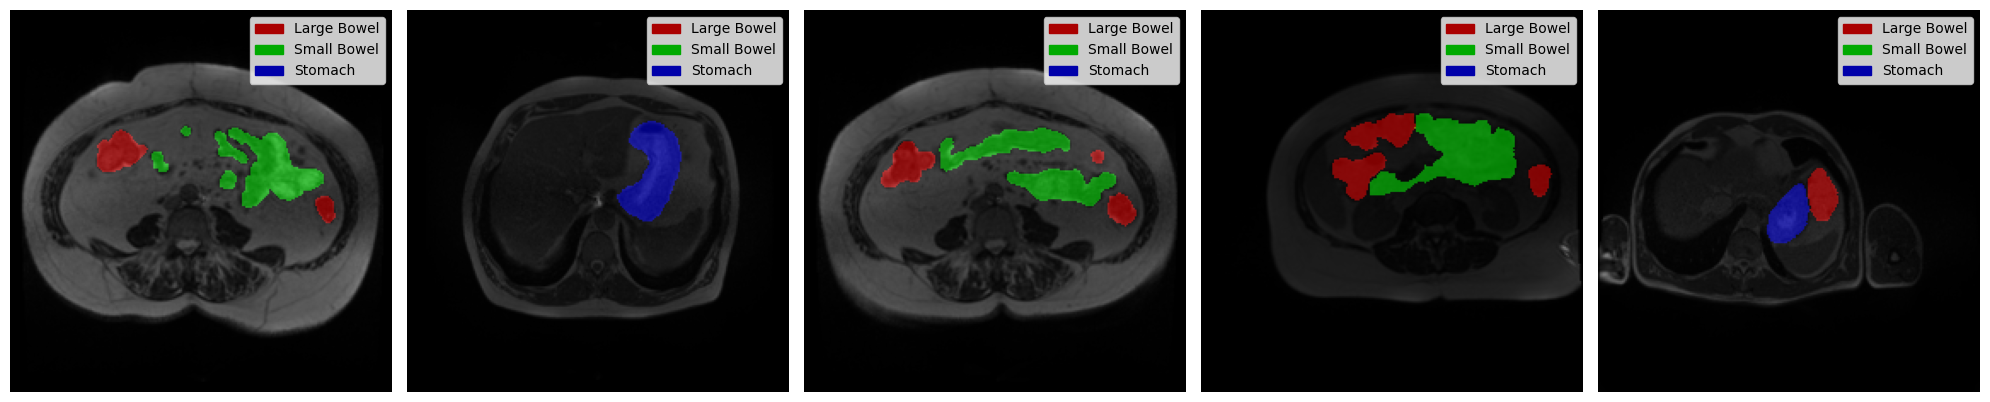

In [65]:
plot_batch(imgs, msks, size=5)

- Predicciones

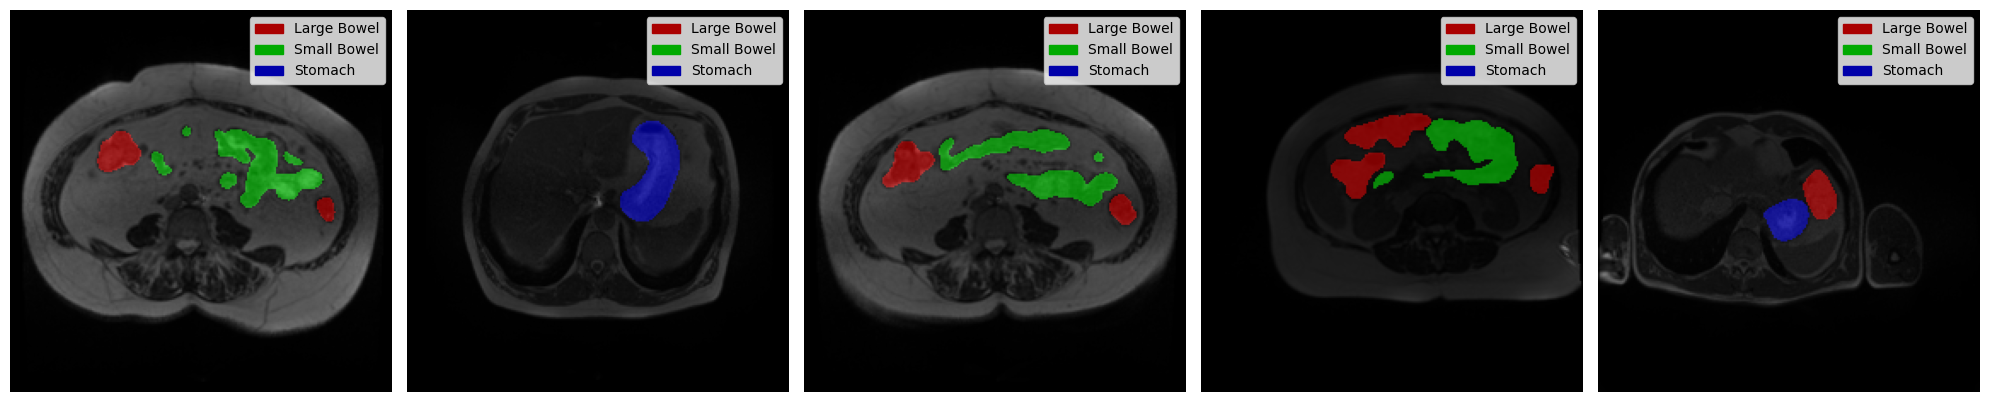

In [66]:
plot_batch(imgs, preds, size=5)

## Test Set

In [ ]:
# Separo la columna id en diferentes columnas: case, day y slice
df_test['case'] = df_test['id'].apply(lambda x: x.split('_')[0].replace('case',''))
df_test['day'] = df_test['id'].apply(lambda x: x.split('_')[1].replace('day',''))
df_test['slice'] = df_test['id'].apply(lambda x: x.split('_')[3])

,id,class,segmentation,case,day,slice
0,case102_day0_slice_0001,large_bowel,NaN,102,0,0001
1,case102_day0_slice_0001,small_bowel,NaN,102,0,0001
2,case102_day0_slice_0001,stomach,NaN,102,0,0001
3,case102_day0_slice_0002,large_bowel,NaN,102,0,0002
4,case102_day0_slice_0002,small_bowel,NaN,102,0,0002


In [ ]:
test_images = glob(os.path.join(CONFIG.test_path, "**", "*.png"), recursive=True)
first_image_path = test_images[0]

x = first_image_path.rsplit("/", 4)[0]

path_partial_list = [os.path.join(x,
                                  "case" + str(df_test["case"].values[i]),
                                  "case" + str(df_test["case"].values[i]) + "_" + "day" + str(df_test["day"].values[i]),
                                  "scans",
                                  "slice_" + str(df_test["slice"].values[i]))
                     for i in range(df_test.shape[0])]
df_test["path_partial"] = path_partial_list
path_partial_list = [str(image_path.rsplit("_", 4)[0]) for image_path in test_images]

tmp_df_test = pd.DataFrame({"path_partial": path_partial_list, "path": test_images})
df_test = df_test.merge(tmp_df_test, on="path_partial").drop(columns=["path_partial"])


df_test.sample(5)

,id,class,segmentation,case,day,slice,path
1972,case101_day26_slice_0082,small_bowel,NaN,101,26,0082,./dataset/test/case101/case101_day26/scans/sli...
396,case102_day0_slice_0133,large_bowel,NaN,102,0,0133,./dataset/test/case102/case102_day0/scans/slic...
872,case101_day20_slice_0003,stomach,NaN,101,20,0003,./dataset/test/case101/case101_day20/scans/sli...
1285,case101_day20_slice_0141,small_bowel,NaN,101,20,0141,./dataset/test/case101/case101_day20/scans/sli...
1837,case101_day26_slice_0037,small_bowel,NaN,101,26,0037,./dataset/test/case101/case101_day26/scans/sli...


In [ ]:
df_test["width"] = df_test["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df_test["height"] = df_test["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
df_test.sample(5)

,id,class,segmentation,case,day,slice,path,width,height
1041,case101_day20_slice_0060,large_bowel,NaN,101,20,0060,./dataset/test/case101/case101_day20/scans/sli...,266,266
1498,case101_day22_slice_0068,small_bowel,NaN,101,22,0068,./dataset/test/case101/case101_day22/scans/sli...,266,266
2093,case101_day26_slice_0122,stomach,NaN,101,26,0122,./dataset/test/case101/case101_day26/scans/sli...,266,266
1608,case101_day22_slice_0105,large_bowel,20354 9 20619 11 20884 14 21150 15 21177 10 21...,101,22,0105,./dataset/test/case101/case101_day22/scans/sli...,266,266
991,case101_day20_slice_0043,small_bowel,NaN,101,20,0043,./dataset/test/case101/case101_day20/scans/sli...,266,266


In [ ]:
# Creo un nuevo dataframe, leyendo 1 cada 3 filas
test_df = pd.DataFrame({'id':df_test['id'][::3]})

# Creo nuevas columnas para cada clase y guardo los valores de los pixeles donde se encuentra ese organo
test_df['large_bowel'] = df_test['segmentation'][::3].values
test_df['small_bowel'] = df_test['segmentation'][1::3].values
test_df['stomach'] = df_test['segmentation'][2::3].values

# Guardo el resto de las columnas creadas en el primer df
test_df['path'] = df_test['path'][::3].values
test_df['case'] = df_test['case'][::3].values
test_df['day'] = df_test['day'][::3].values
test_df['slice'] = df_test['slice'][::3].values
test_df['width'] = df_test['width'][::3].values
test_df['height'] = df_test['height'][::3].values

# Creo nuevo indice y cambio NaN por string vacio
test_df.reset_index(inplace=True,drop=True)
test_df.fillna('',inplace=True);

# Agrego nueva columna que indica cuantos objetos hay presentes en la imagen (0, 1, 2 o 3)
test_df['count'] = np.sum(test_df.iloc[:,1:4]!='',axis=1).values
test_df.sample(10)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
596,case101_day26_slice_0021,,,,./dataset/test/case101/case101_day26/scans/sli...,101,26,0021,266,266,0
342,case101_day20_slice_0055,,,,./dataset/test/case101/case101_day20/scans/sli...,101,20,0055,266,266,0
325,case101_day20_slice_0038,,,,./dataset/test/case101/case101_day20/scans/sli...,101,20,0038,266,266,0
620,case101_day26_slice_0045,,,,./dataset/test/case101/case101_day26/scans/sli...,101,26,0045,266,266,0
587,case101_day26_slice_0012,,,,./dataset/test/case101/case101_day26/scans/sli...,101,26,0012,266,266,0
338,case101_day20_slice_0051,,,,./dataset/test/case101/case101_day20/scans/sli...,101,20,0051,266,266,0
457,case101_day22_slice_0026,,,,./dataset/test/case101/case101_day22/scans/sli...,101,22,0026,266,266,0
422,case101_day20_slice_0135,,,,./dataset/test/case101/case101_day20/scans/sli...,101,20,0135,266,266,0
308,case101_day20_slice_0021,,,,./dataset/test/case101/case101_day20/scans/sli...,101,20,0021,266,266,0
84,case102_day0_slice_0085,,,34446 4 34805 8 35163 12 35520 17 35878 19 362...,./dataset/test/case102/case102_day0/scans/slic...,102,0,0085,360,310,1


In [118]:
test_dataset = BuildDataset(test_df,
                            augment=data_augmentation['valid'])

test_loader  = DataLoader(test_dataset,
                          batch_size=5,
                          num_workers=2,
                          shuffle=True,
                          pin_memory=True)

imgs, msks =  next(iter(test_loader))

imgs = imgs.to(CONFIG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-05.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

- Mascaras

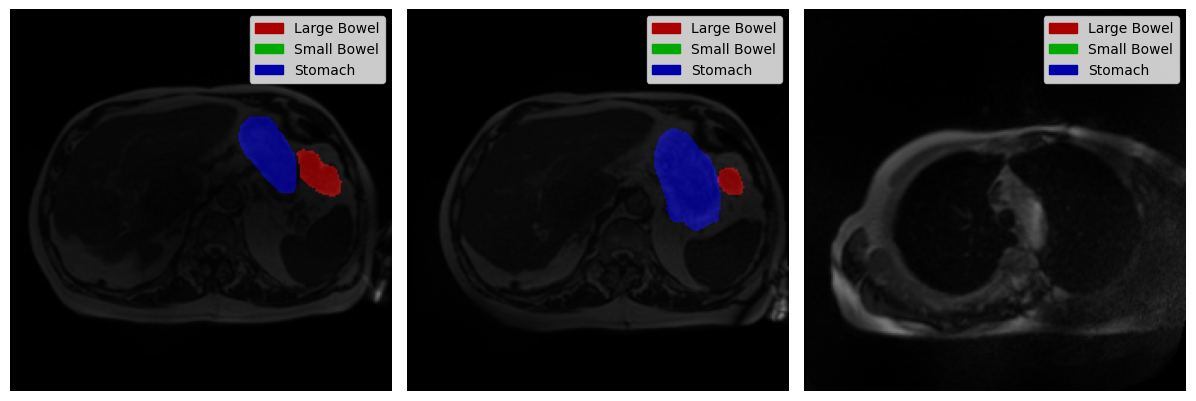

In [121]:
plot_batch(imgs, msks, size=3)

- Predicciones

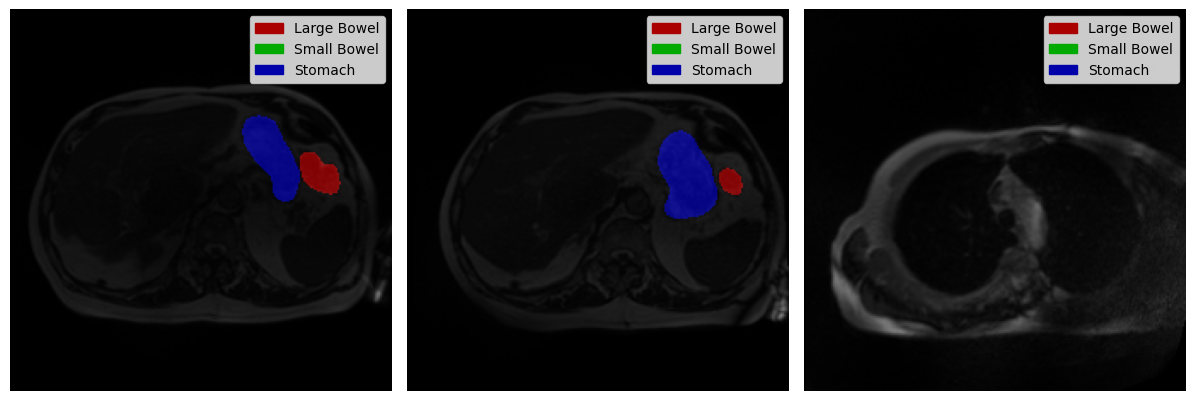

In [122]:
plot_batch(imgs, preds, size=3)

In [124]:
test_dataset = BuildDataset(test_df,
                            augment=data_augmentation['valid'])

test_loader  = DataLoader(test_dataset,
                          batch_size=5,
                          num_workers=2,
                          shuffle=True,
                          pin_memory=True)

imgs, msks =  next(iter(test_loader))

imgs = imgs.to(CONFIG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-05.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

- Mascaras

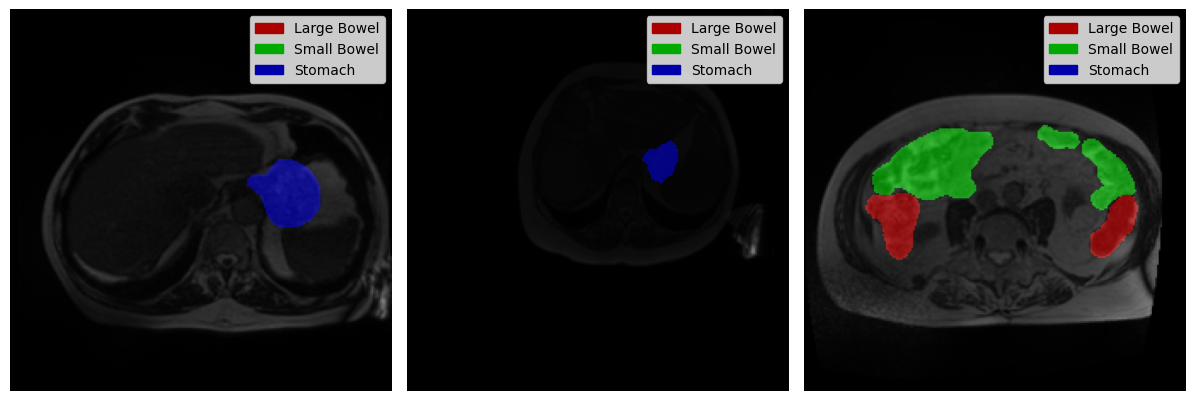

In [125]:
plot_batch(imgs, msks, size=3)

- Predicciones

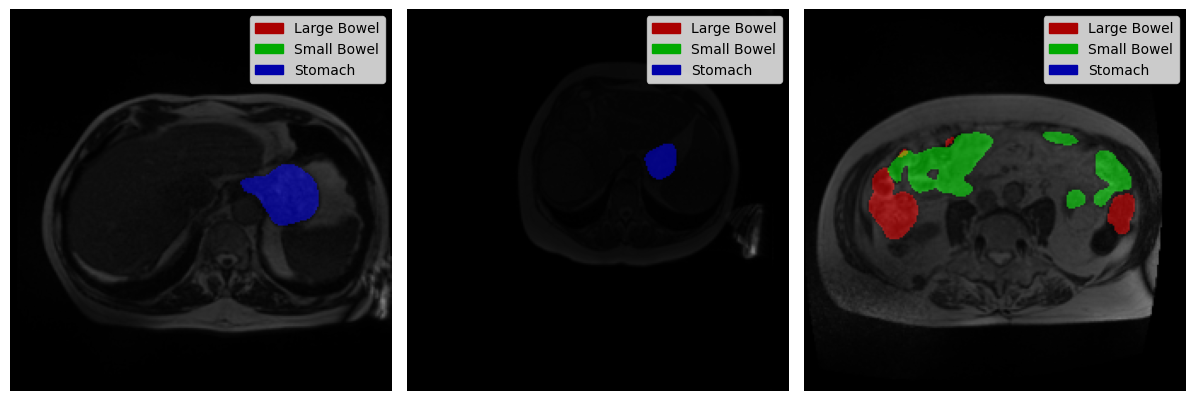

In [126]:
plot_batch(imgs, preds, size=3)